In [9]:
import torch
import torch.nn as nn
import torchvision 
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [10]:
# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Hyper parameters
input_size = 784 # 28*28 (We will flatten image to be a 1-D array)
hidden_size = 100 # You can try out different sizes
num_classes = 10 # digits from 0 to 9
epochs = 2 # You can set this to a higher value (this is just for quicker demo)
batch_size = 100
learning_rate = 0.01

In [12]:
# Import MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=T.ToTensor(),
    download=True # should be downloaded if not available already
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=T.ToTensor() 
    # No neede to download it anymore
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) # Shuffling doesn't matter for the evaluation

# Let's see one batch
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)
# FROM ABOVE: torch.Size([100, 1, 28, 28]) -> 100 batches, 1 channel (only one color), 28, 28

torch.Size([100, 1, 28, 28]) torch.Size([100])


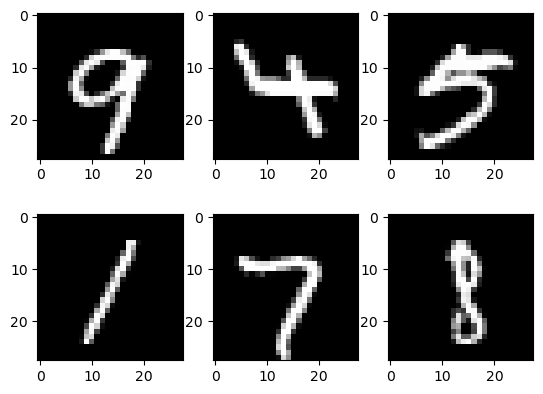

In [13]:
# print 6 examples
for i in range(6):
    plt.subplot(2, 3, i+1) # 2 rows, 3 cols
    plt.imshow(samples[i][0], cmap='gray') # [0] for first channel

plt.show()

In [14]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        # We usually do not add the activation function here for Multiclass Classification

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)  
        out = self.l2(out)
        # we will use the cross-entropy loss, which will apply the SoftMax for us
        return out

In [15]:
model = NeuralNet(input_size, hidden_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # PS: This will apply the softmax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
# Adam is an alternative method for Stochastic Gradient Descent
# Adam vs SGD: https://towardsai.net/p/l/why-should-adam-optimizer-not-be-the-default-learning-algorithm

# Training Loop
n_total_steps = len(train_loader)

for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        # reshape our image first -> From [100, 1, 28, 28] to [100, 784]
        # 'to()' will push it to either the CPU or GPU
        images = images.reshape(-1, 28*28).to(device) # '-1' means that tensor will automatically find that for us
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) # predictions ('outputs') vs actual Y ('labels')

        # backward pass
        optimizer.zero_grad() # empty the gradients
        loss.backward()
        optimizer.step() # update setp (udpate the parameters for us)

        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1} / {epochs}, step: {i+1} / {n_total_steps}, loss: {loss.item():.4f}')

epoch: 1 / 2, step: 100 / 600, loss: 0.4195
epoch: 1 / 2, step: 200 / 600, loss: 0.2409
epoch: 1 / 2, step: 300 / 600, loss: 0.2906
epoch: 1 / 2, step: 400 / 600, loss: 0.1354
epoch: 1 / 2, step: 500 / 600, loss: 0.0949
epoch: 1 / 2, step: 600 / 600, loss: 0.0880
epoch: 2 / 2, step: 100 / 600, loss: 0.1779
epoch: 2 / 2, step: 200 / 600, loss: 0.0664
epoch: 2 / 2, step: 300 / 600, loss: 0.1091
epoch: 2 / 2, step: 400 / 600, loss: 0.1800
epoch: 2 / 2, step: 500 / 600, loss: 0.2639
epoch: 2 / 2, step: 600 / 600, loss: 0.1065


In [17]:
# Test (evaluation)

# we don't want to compute the gradients for the steps
with torch.no_grad():
    n_correct_pred = 0
    n_samples = 0

    for images, labels in test_loader:
        # reshape them as well
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images) # Our model is already trained here

        # returns value, index (only interested in the latter, which is the class label)
        _, predictions = torch.max(outputs, 1) # dimension 1
        n_samples += labels.shape[0] # number of samples in the current batch (here it is 100)
        n_correct_pred += (predictions == labels).sum().item() # Each correct prediciton will add 1

    acc = 100.0 * (n_correct_pred / n_samples)
    print(f'accuracy: {acc}%')

accuracy: 96.07%
